In [17]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                AutoMinorLocator)

import warnings
import arviz as az
import numpy as np
import pymc3 as pm
import theano.tensor as tt                                       
from scipy.integrate import solve_ivp
from scipy.stats import norm      
import numpy as numpy

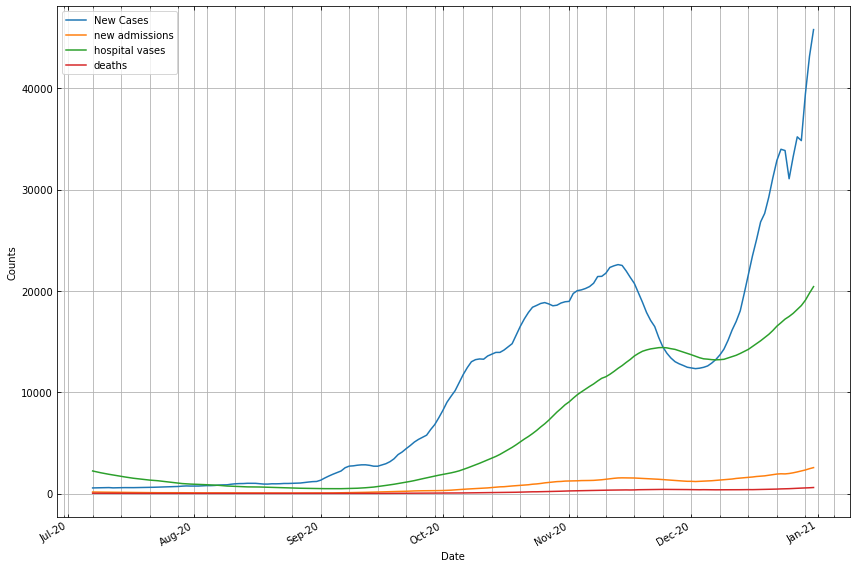

In [18]:
weeks = mdates.WeekdayLocator()
years = mdates.YearLocator()
months = mdates.MonthLocator()
weekdays = mdates.DayLocator()
dateFmt = mdates.DateFormatter('%b-%y')
dateFmt_day = mdates.DateFormatter('%d-%b')


def rolling_avg_df(dfs, N=7):
     # Define a rolling average function
     dfs = dfs.loc[:].rolling(N, win_type="boxcar").mean()
     return dfs

query = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaName={}&metric=hospitalCases&metric=newAdmissions&metric=newCasesBySpecimenDate&metric=newDeaths28DaysByDeathDate&format=csv'
area = 'England'
df = pd.read_csv(query.format(area))
df.set_index(pd.to_datetime(df['date']),inplace=True)
df.sort_index(inplace=True)

#truncate in dates if required
df = df.truncate(before=dt.datetime(2020,7,1),after=dt.datetime(2020,12,31))
# df.truncate(before=dt.datetime(2020,1,8),after=dt.datetime(2020,12,31))

fig, ax = plt.subplots(figsize=(12,8),sharex= True, facecolor='white')
ax.plot(df.index,rolling_avg_df(df['newCasesBySpecimenDate']), label = 'New Cases') # daily number of new cases
ax.plot(df.index,rolling_avg_df(df['newAdmissions']), label = 'new admissions') # daily number of new admissions to hospital of patients with COVID-19
ax.plot(df.index,rolling_avg_df(df['hospitalCases']), label = 'hospital vases') # daily number of confirmed COVID-19 patients in hospital
ax.plot(df.index,rolling_avg_df(df['newDeaths28DaysByDeathDate']), label = 'deaths') # Daily numbers of people who died within 28 days of being identified as a COVID-19 case by a positive test. Data are shown by date of death.

# save data for daily number of new cases




ax.legend()
ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Counts')
# ax.set_yscale('log')
#ax.set_title('{} Cases'.format(reg))

# format the ticks
month_dateFmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)

#ax.xaxis.set_major_locator(weeks)
#ax.xaxis.set_major_formatter(dateFmt_day)
#ax.xaxis.set_minor_locator(weekdays)

ax.tick_params(axis="both", direction="in", which="both", 
right=True,left=True, top=True, bottom=True)

#ax.legend(ncol=1, title='')
_= fig.autofmt_xdate()

plt.tight_layout()

In [19]:
def sir_odes(t, x, b1,b2,b3,b4,b5, g1,g2,g3,g4,g5, N):
    "SIR Model"
    if t <= 25:
        b = b1
        g = g1
    elif 25 < t <= 50:
        b = b2
        g = g2
    elif 50 < t <= 75:
        b = b3
        g = g3
    elif 75 < t <= 100 :
        b = b4
        g = g4
    elif 100 < t :
        b = b5
        g = g5
        
    S = x[0]
    I = x[1]
    R = x[2]


    dSdt = -(b/N)*S*I
    dIdt = (b/N)*S*I - g*I
    dRdt = g*I
    case = (b/N)*S*I
   
    
    return dSdt, dIdt, dRdt

In [20]:
new_cases_I = rolling_avg_df(df['newCasesBySpecimenDate'])
new_cases = new_cases_I.dropna()
data = new_cases

In [ ]:
def log_likelihood(solve_ivp, sir_odes, t_span, x_0, theta , t,  data):


    sol = solve_ivp(sir_odes, t_span , x_0, args = theta , t_eval = t)
    
    S = sol.y[0]
    I = sol.y[1]
    I[0:25] = I[0:25] * theta[0]
    I[25:50] = I[25:50] * theta[1]
    I[50:75] = I[50:75] * theta[2]
    I[75:100] = I[75:100] * theta[3]
    I[100:125] = I[100:125] * theta[4]
   
    I = (np.multiply(S,I))/ theta[-1]
        
    logp = -0.5*np.sum(np.square((data[0:125] - I)))#/(np.std((data))**2)

    return logp


## Wrapper classes to theano-ize LogLklhood and gradient...
class Loglike(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dscalar]

    def __init__(self, solve_ivp, sir_odes, t_span,x_0, t, data):
        self.data = data
        self.solve_ivp = solve_ivp
        self.sir_odes = sir_odes
        self.t_span = t_span
        self.x_0 = x_0
        self.t = t
        # self.loglike_grad = LoglikeGrad(self.data, self.t)

    def perform(self, node, inputs, outputs):
        (theta,) = inputs 
        logp = log_likelihood(self.solve_ivp,self.sir_odes, self.t_span,self.x_0, theta , self.t, self.data)
        
        outputs[0][0] = np.array(logp)


t_span_1 = np.array([1, 125])  # Time limits
t = np.linspace(t_span_1[0], t_span_1[1], t_span_1[1] ) # Time series, but want to only sample for period 1: 115
x_0 = np.array([54000000 - new_cases[0] , new_cases[0], 0]) 
N = np.sum(x_0)

chi_store = []
loglike = Loglike(solve_ivp, sir_odes,t_span_1 ,x_0, t, data)

with pm.Model() as model:
   
    
    b_1 = pm.Uniform('b_1',lower = 0, upper = 5)
    b_2 = pm.Uniform('b_2',lower = 0, upper = 5)
    b_3 = pm.Uniform('b_3',lower = 0, upper = 5)
    b_4 = pm.Uniform('b_4',lower = 0, upper = 5)
    b_0 = pm.Uniform('b_0',lower = 0, upper = 5)
    
    g_1 = pm.Uniform('g_1', lower = 0, upper = 5)
    g_2 = pm.Uniform('g_2', lower = 0, upper = 5)
    g_3 = pm.Uniform('g_3', lower = 0, upper = 5)
    g_4 = pm.Uniform('g_4', lower = 0, upper = 5)
    g_0 = pm.Uniform('g_0', lower = 0, upper = 5)  
        
    
    
    theta = tt.as_tensor_variable([b_1,b_2,b_3,b_4,b_0,g_1,g_2,g_3,g_4,g_0,N])

    pm.Potential("like", loglike(theta))

with model:
    trace = pm.sample(draws = 1000, chains = 6, tune = 500, cores  = 1)
    # trace = pm.sample(step=pm.NUTS())
    # idata = pm.sample(return_inferencedata=True)
    print(pm.summary(trace).to_string())

# b_1 = trace["b_1"]
# g_1 = trace["g_1"]
# chi_store1 = []

# for b_1, g_1 in zip(b_1, g_1):
#     chi_value = 1
#     chi_store1.append(chi_value)
    
# chains = np.column_stack([chi_store1, trace["b_1"] ,trace["g_1"]])
# datafile_path = "chain_SIR_p1"
# np.savetxt(datafile_path , chains, fmt=['%f','%f','%f'])



# b_2 = trace["b_2"]
# g_2 = trace["g_2"]
# chi_store2 = []

# for b_2, g_2 in zip(b_2, g_2):
#     chi_value = 1
#     chi_store2.append(chi_value)
    
# chains = np.column_stack([chi_store2, trace["b_2"] ,trace["g_2"]])
# datafile_path = "chain_SIR_p2"
# np.savetxt(datafile_path , chains, fmt=['%f','%f','%f'])



# b_3 = trace["b_3"]
# g_3 = trace["g_3"]
# chi_store3 = []

# for b_3, g_3 in zip(b_3, g_3):
#     chi_value = 1
#     chi_store3.append(chi_value)
    
# chains = np.column_stack([chi_store3, trace["b_3"] ,trace["g_3"]])
# datafile_path = "chain_SIR_p3"
# np.savetxt(datafile_path , chains, fmt=['%f','%f','%f'])



# b_4 = trace["b_4"]
# g_4 = trace["g_4"]
# chi_store4 = []

# for b_4, g_4 in zip(b_4, g_4):
#     chi_value = 1
#     chi_store4.append(chi_value)
    
# chains = np.column_stack([chi_store4, trace["b_4"] ,trace["g_4"]])
# datafile_path = "chain_SIR_p4"
# np.savetxt(datafile_path , chains, fmt=['%f','%f','%f'])


# b_5 = trace["b_5"]
# g_5 = trace["g_5"]
# chi_store5 = []

# for b_5, g_5 in zip(b_5, g_5):
#     chi_value = 1
#     chi_store5.append(chi_value)
    
# chains = np.column_stack([chi_store5, trace["b_5"] ,trace["g_5"]])
# datafile_path = "chain_SIR_p5"
# np.savetxt(datafile_path , chains, fmt=['%f','%f','%f'])


C:\Users\sulai\AppData\Local\Temp/ipykernel_14852/1705717979.py:72: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = 1000, chains = 6, tune = 500, cores  = 1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (6 chains in 1 job)
CompoundStep
>Slice: [g_0]
>Slice: [g_4]
>Slice: [g_3]
>Slice: [g_2]
>Slice: [g_1]
>Slice: [b_0]
>Slice: [b_4]
>Slice: [b_3]
>Slice: [b_2]
>Slice: [b_1]


Sampling 6 chains for 500 tune and 1_000 draw iterations (3_000 + 6_000 draws total) took 13755 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
b_1  2.501  0.003   2.500    2.507      0.001    0.001       6.0      11.0   5.79
b_2  2.500  0.001   2.499    2.500      0.000    0.000       6.0      11.0   5.75
b_3  2.501  0.002   2.500    2.505      0.001    0.001       6.0      11.0   5.81
b_4  2.509  0.018   2.500    2.548      0.007    0.005       6.0      11.0   5.83
b_0  2.493  0.008   2.476    2.500      0.003    0.003       6.0      11.0   5.75
g_1  2.503  0.007   2.499    2.518      0.003    0.002       6.0      11.0   5.70
g_2  2.495  0.009   2.476    2.501      0.004    0.003       6.0      11.0   5.76
g_3  2.495  0.014   2.466    2.508      0.006    0.004       6.0      11.0   5.02
g_4  2.498  0.005   2.488    2.502      0.002    0.001       6.0      11.0   5.83
g_0  2.383  0.033   2.349    2.434      0.014    0.010       6.0      11.0   5.83


In [ ]:
b_0 = trace["b_0"]
g_0 = trace["g_0"]

chi_store = []
for b_0, g_0 in zip(b_0, g_0 ):
    
#     args = (b_a, b_sy, g_a, g_sy, e_a, e_sy, a, N) 
#     sol = solve_ivp(seasyr_odes, t_span, x_0, args=(args), t_eval=t)
    
#     E = sol.y[1]
    
    chi_value = 1
    chi_store.append(chi_value)
    
chains = np.column_stack([ chi_store, trace["b_0"] ,trace["g_0"]])
datafile_path = "chain_SIR_cono"
np.savetxt(datafile_path , chains, fmt=['%f','%f','%f'])

In [16]:
b_4 = trace["b_4"]
g_4 = trace["g_4"]

chi_store = []
for b_4, g_4 in zip(b_4, g_4 ):
    
#     args = (b_a, b_sy, g_a, g_sy, e_a, e_sy, a, N) 
#     sol = solve_ivp(seasyr_odes, t_span, x_0, args=(args), t_eval=t)
    
#     E = sol.y[1]
    
    chi_value = 1
    chi_store.append(chi_value)
    
chains = np.column_stack([ chi_store, trace["b_4"] ,trace["g_4"]])
datafile_path = "chain_SIR_con"
np.savetxt(datafile_path , chains, fmt=['%f','%f','%f'])

In [ ]:
b_3 = trace["b_3"]
g_3 = trace["g_3"]

chi_store = []
for b_3, g_3 in zip(b_3, g_3 ):
    
#     args = (b_a, b_sy, g_a, g_sy, e_a, e_sy, a, N) 
#     sol = solve_ivp(seasyr_odes, t_span, x_0, args=(args), t_eval=t)
    
#     E = sol.y[1]
    
    chi_value = 1
    chi_store.append(chi_value)
    
chains = np.column_stack([ chi_store, trace["b_3"] ,trace["g_3"]])
datafile_path = "chain_SIR_co"
np.savetxt(datafile_path , chains, fmt=['%f','%f','%f'])

In [ ]:
b_2 = trace["b_2"]
g_2 = trace["g_2"]

chi_store = []
for b_2, g_2 in zip(b_2, g_2 ):
    
#     args = (b_a, b_sy, g_a, g_sy, e_a, e_sy, a, N) 
#     sol = solve_ivp(seasyr_odes, t_span, x_0, args=(args), t_eval=t)
    
#     E = sol.y[1]
    
    chi_value = 1
    chi_store.append(chi_value)
    
chains = np.column_stack([ chi_store, trace["b_2"] ,trace["g_2"]])
datafile_path = "chain_SIR_c"
np.savetxt(datafile_path , chains, fmt=['%f','%f','%f'])

In [ ]:
b_1 = trace["b_1"]
g_1 = trace["g_1"]

chi_store = []
for b_1, g_1 in zip(b_1, g_1 ):
    
#     args = (b_a, b_sy, g_a, g_sy, e_a, e_sy, a, N) 
#     sol = solve_ivp(seasyr_odes, t_span, x_0, args=(args), t_eval=t)
    
#     E = sol.y[1]
    
    chi_value = 1
    chi_store.append(chi_value)
    
chains = np.column_stack([ chi_store, trace["b_1"] ,trace["g_1"]])
datafile_path = "chain_SIR_"
np.savetxt(datafile_path , chains, fmt=['%f','%f','%f'])

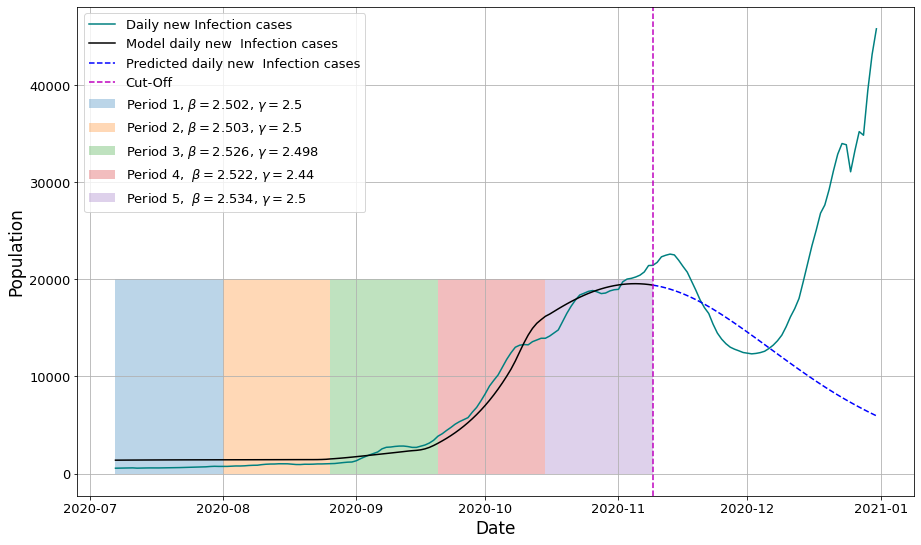

In [86]:
lc = len(new_cases)
t_span = np.array([1, lc])  # Time limits
t = np.linspace(t_span[0], t_span[1], t_span[1] ) 

x_0 = np.array([54000000 - new_cases[0] , new_cases[0], 0])  # Initial conditions for model variables: S, I, R respectively
N = np.sum(x_0)
theta = [2.5020173671836976, 2.503468027681488, 2.526416327097504, 2.521772097669426, 2.534317091723745 ,2.500047366353557, 2.500229768948729, 2.4985206901565467, 2.4412210720171874, 2.5000117860937694  , N]
# theta = [b_1,b_2,b_3,b_4,b_0,g_1,g_2,g_3, g_4 , g_0, N]

sol = solve_ivp(sir_odes, t_span , x_0, args = theta , t_eval = t)
S = sol.y[0]
I = sol.y[1] 
R = sol.y[2]
I_up = sol.y[1]

I[0:25] = I[0:25] * theta[0]
I[25:50] = I[25:50] * theta[1]
I[50:75] = I[50:75] * theta[2]
I[75:100] = I[75:100] * theta[3]
I[100:] = I[100:] * theta[4]

I = (np.multiply(S,I))/ theta[-1]




plt.figure(figsize=(15,9))
plt.plot(dates2,data,label = 'Daily new Infection cases',color='teal')
plt.plot(dates2[0:126],I[0:126],label = r'Model daily new  Infection cases', color = 'black')
plt.plot(dates2[125:],I[125:],label = r'Predicted daily new  Infection cases', color = 'b', ls = '--')
plt.xlabel("Date", fontsize = 17)
plt.ylabel("Population", fontsize = 17)

plt.fill_betweenx([0,20000], dates2[0], dates2[25], alpha = 0.3, label = r'Period 1, $\beta = 2.502$, $\gamma = 2.5$')
plt.fill_betweenx([0,20000], dates2[25], dates2[50], alpha = 0.3, label = r'Period 2, $\beta = 2.503$, $\gamma = 2.5$')
plt.fill_betweenx([0,20000], dates2[50], dates2[75], alpha = 0.3, label = r'Period 3, $\beta = 2.526$, $\gamma = 2.498$')
plt.fill_betweenx([0,20000], dates2[75], dates2[100], alpha =0.3, label = r'Period 4,  $\beta = 2.522$, $\gamma = 2.44$')
plt.fill_betweenx([0,20000], dates2[100], dates2[125], alpha = 0.3, label = r'Period 5,  $\beta = 2.534$, $\gamma = 2.5$')
plt.axvline(dates2[125:126], c = 'm',ls = '--', label = 'Cut-Off')
plt.legend(fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()



plt.savefig('SIRH_5_PRED')
plt.show()




